# Введение

В данной работе мы проведём кластерный анализ аудитории публичных страниц в социальных сетях. В качестве анализируемой соц. сети выбор пал на "Вконтакте". 
Вот основные причины по которым мы выбрали этот ресурс: 
- Он является одним из самых популярных в русскоязычном интернете. Из этого следует большое количество материала для анализа.
- Есть апи разработчиков, через который можно удобно получать данные (Правда, вк таки скупы на выдачу данных через этот апи, через несколько тысяч запросов, они его блокируют для конкретного пользователя).

Какие данные будем собирать? Помимо основных данных (Пол, возраст, занятость и т.д.), попытаемся собрать интересы и увлечения пользователей, но не те, которые они обычно указывают на своих страницах в разделе "О себе", а мы попробуем выяснить чем интересуются пользователи, по тому, на что они подписаны. Если мы зайдем на страницу к пользователю и у него открытый аккаунт, то мы сможем увидеть, топ 5 пабликов, куда он чаще всего заходит, и проявляет там всяческую активность. На основе этих данных мы и будем пытаться сегментировать людей.


# <img src="1.png" style="width: 50%;"/>


Тема данной работы заключается в анализе аудитории трёх довольно крупных пабликов вконтакте, это паблики: https://vk.com/tnt, https://vk.com/ctc, https://vk.com/matchtv.
Довольно крупные паблики с аудиторией от 2.5 миллионов до 5 миллионов подписчиков.

Этот notebook состоит из двух частей: 1 часть, это сбор данных из вк, 2 часть это непосредственно анализ этих данных 

# Часть 1: Сбор данных из вконтакте

Для начала, надо решить, какие конкретно данные мы хотим собрать.
Метод апи вк API.users.get работает по принципу:
- Передаём туда список айди пользователей
- Передаём списков полей (fields), которые хотим получить (описание полей тут: https://vk.com/dev/objects/user)
- Получаём список объектов пользователей вместе с нужными нам полями для каждого
- PROFIT!!!

В качестве полей, которые бдем получать от юзера были выбраны:
- sex- пол
- bdate - дата рождения
- city - город
- country - страна
- followers_count - количество подписчиков
- occupation - род занятий

Теперь, нужно добыть списки айди страниц подписчиков этих пабликов. 
У апи вк есть метод API.groups.getMembers, 
- Передаём туда адрес паблика, смещение и кол-во возвращаемых объектов.
- На выходе получаем список айди пользователей


Но, у наших пабликов по несколько миллионов подписчиков, а этот метод возвращает не более 1000 айди за раз.
Получается, для 1 миллиона айдишников, нам надо сделать 1000 запросов, а для 5 миллионов - 5000 запросов!. Также, в секунду не более 3 запросов.

Теперь посчитаем: <br>
5.000.000 / 1.000 / 3 ~ 1667 секунд или почти полчаса. 

Ладно, полчаса не так уж и много, можно отдохнуть и попить чай. Но, спамить вк запросами не хочется, он нас заблокирует очень быстро.
Поэтому, используем метод API.execute - этот метод позволяет выполнить до 25 запросов на стороне вк, то есть, мы передаём туда код (код состоит из немного урезанного javascript'a) и получаем нужный нам ответ. 
В итоге, вместо 1000 айди, за один запрос к вк, мы можем получить до 25000 айди.

Опять немного арифметики: <br>
5.000.000 / 25.000 = 200 - запросов, неплохая оптимизация, всего 200 запросов вместо 5000.

200 / 3 ~ 66 секунд, ну или чуть больше минуты. 


Когда айди будут получены, нужно будет получить по каждому айди информацию о пользователе, для этого есть метод: API.users.get. За один запрос к этому методу, мы можем получить информацию не более чем по 1000 айди. Опять же, используем API.execute, чтобы получить больше пользователей. Т.к. ответ API.execute не должен превышать 5 мегабайт, то одновременно будем получать 6000 пользвателей, то есть, внутри одного API.execute - 6 API.users.get.



После того как списки пользователей будут получены оставим только тех юзеров у которых заполненны все запрошенные поля.

Далее получим список подписок для каждого пользователя. Делать это через открытый апи вк уже не так эффективно. 
За один запрос мы можем получить информацию только по одному пользователю. То есть, для миллиона юзеров - миллион запросов. Апи вк нас заблокирует. 

Чтобы решить эту проблему, будем слать запросы с помощью модуля requests напрямую к вк. Не к открытому апи, а к тому апи, к которому обращается клиентская часть браузера (фронтенд). Это удобнее чем парсить всю страницу, так как мы получаем только список групп в формате json. 

Чтобы узнать url и необходимые заголовки для запроса нужно:
- Зайти в вк на страницу какого-нибудь пользователя через браузер (chrome, firefox)
- Открыть инструменты разработчика и  вкладку "Network"
- Нажать на блок "Подписки"

После нажатия браузер начнёт подгружать список пабликов, чтобы их отобразить. Тут то мы и вычислим куда вк шлёт запросы и с какими данными, чтобы подгрузить список подписок.

# <img src="2.png" style="width: 50%;"/>

В итоге, данные для каждой группы будут собираться в 3 этапа:
1. Получить все айди подписчиков 
2. Получить по каждому айди нужную нам информацию профиля и отфильтровать незаполненные аккаунты
3. Получить по каждому юзеру список подписок

На каждом этапе будем сохранять данные в .csv файлы, чтобы в случае сбоев не пришлось всё заново загружать. 
Также на каждом шаге будем считывать данные из .csv, чтобы мы могли запускасть этапы независимо друг от друга.

Хорошо, теперь код всего вышесказанного:

In [1]:
# Нужные импорты
import vk
import time
import pandas as pd
import auth_data

In [ ]:
# Данные авторизации
session = vk.AuthSession(access_token=auth_data.TOKEN, 
                         user_login=auth_data.LOGIN, 
                         user_password=auth_data.PASSWORD, 
                         scope='all', 
                         app_id=auth_data.APP_ID)
vk_api = vk.API(session)

In [ ]:
# Код на javascript, который мы будем передавать в API.execute 
# var offset = %i;  - смещение
# var group = "%s"; - айди группы
CODE_FOR_ALL_MEMBERS_IDS = '''
var offset = %i; 
var group = "%s";
var all_members_list = [];
var i = 0;
var members;


while (i < 25) {
	members = API.groups.getMembers({"group_id": group, "offset": offset, "count": 1000});

	if (members.items.length == 0) {
		return all_members_list;
	}

	all_members_list.push(members.items);
	i = i + 1;	
	offset = offset + 1000;	
}

return all_members_list;
'''


CODE_FOR_GET_USERS = '''
var user_ids1 = "%s";
var user_ids2 = "%s";
var user_ids3 = "%s";
var user_ids4 = "%s";
var user_ids5 = "%s";
var user_ids6 = "%s";
var fields = "%s";
var users = [];
users.push(API.users.get({"user_ids": user_ids1, "fields": fields}));
users.push(API.users.get({"user_ids": user_ids2, "fields": fields}));
users.push(API.users.get({"user_ids": user_ids3, "fields": fields}));
users.push(API.users.get({"user_ids": user_ids4, "fields": fields}));
users.push(API.users.get({"user_ids": user_ids5, "fields": fields}));
users.push(API.users.get({"user_ids": user_ids6, "fields": fields}));
return users;
'''


FIELDS = ['sex',
          'bdate',
          'city',
          'country',
          'followers_count',
          'occupation']

In [3]:
# Получить все айди подписчиков паблика, на выходе питоновский список
def get_all_member_ids_from_group(vk_api, group):
    all_members_list = []
    offset = 0
    while True:
        members = vk_api.execute(code=CODE_FOR_ALL_MEMBERS_IDS % (offset, group), v=5.73)
        if not members:
            break
        for i in members:
            all_members_list.extend(i)
        offset += 25_000
        time.sleep(0.35)
    return all_members_list

# Записать все айди в .csv файл
def write_member_ids_to_csv(members_ids, filename):
    df = pd.DataFrame(data={"members": members_ids})
    df.to_csv(filename, sep=',', index=False)
    
    
# Запрос к апи вк. На стороне вк выполняем код 
# 6000 юзеров выбрано потому, что ответ execute не должен превышать 5 мегабайт  
def get_part_users(vk_api, user_ids1, user_ids2, user_ids3, user_ids4, user_ids5, user_ids6):
    users = vk_api.execute(code=CODE_FOR_GET_USERS % (user_ids1, user_ids2,
                                                             user_ids3, user_ids4,
                                                             user_ids5, user_ids6,
                                                             ','.join(FIELDS)),
                           v=5.73)
    user_id = []
    sex = []
    bdate = []
    city_id = []
    country_id = []
    occupation = []
    followers_count = []
    for part in users:
        for user in part:
            user_id.append(user['id'])
            sex.append(user.get('sex'))
            bdate.append(user.get('bdate'))
            followers_count.append(user.get('followers_count'))

            if user.get('city'):
                city_id.append(user['city']['id'])
            else:
                city_id.append(None)

            if user.get('country'):
                country_id.append(user['country']['id'])
            else:
                country_id.append(None)

            if user.get('occupation'):
                occupation.append(user['occupation']['type'])
            else:
                occupation.append(None)

    data = pd.DataFrame()
    data['user_id'] = pd.Series(user_id, dtype=int)
    data['sex'] = pd.Series(sex, dtype=int)
    data['followers_count'] = pd.Series(followers_count)
    data['city_id'] = pd.Series(city_id)
    data['country_id'] = pd.Series(country_id)
    data['occupation'] = pd.Series(occupation)
    data['bdate'] = pd.Series(bdate)
    return data

    
# Получить всех юзеров из списка айди
# 6000 юзеров выбрано потому, что ответ execute не должен превышать 5 мегабайт  
def get_users(vk_api, user_ids):
    df = None
    k = 0
    while k < len(user_ids):
        user_ids1 = ','.join(user_ids[k:k + 1000])
        user_ids2 = ','.join(user_ids[k + 1000:k + 2000])
        user_ids3 = ','.join(user_ids[k + 2000:k + 3000])
        user_ids4 = ','.join(user_ids[k + 3000:k + 4000])
        user_ids5 = ','.join(user_ids[k + 4000:k + 5000])
        user_ids6 = ','.join(user_ids[k + 5000:k + 6000])

        k += 6000

        try:
            piece_df = get_part_users(vk_api, user_ids1, user_ids2, user_ids3, user_ids4, user_ids5, user_ids6)
        except:
            time.sleep(1)
            piece_df = get_part_users(vk_api, user_ids1, user_ids2, user_ids3, user_ids4, user_ids5, user_ids6)

        if df is not None:
            df = df.append(piece_df, ignore_index=True)
        else:
            df = piece_df
        
        print('\r', end='')
        print(f'{round(len(df) / len(user_ids), 2)} %', end='')
    return df

<h3>Этап 1: Сбор айди пользователей</h3>

Для паблика тнт:

In [ ]:
tnt_member_ids = get_all_member_ids_from_group(vk_api, 'tnt')
write_member_ids_to_csv(tnt_member_ids, 'member_ids_tnt.csv')

Для матч тв:

In [ ]:
matchtv_member_ids = get_all_member_ids_from_group(vk_api, 'matchtv')
write_member_ids_to_csv(matchtv_member_ids, 'member_ids_matchtv.csv')

Для стс:

In [ ]:
ctc_member_ids = get_all_member_ids_from_group(vk_api, 'ctc')
write_member_ids_to_csv(ctc_member_ids, 'member_ids_ctc.csv')

<h3>Этап 2: Сбор информации по каждому юзеру</h3>

тнт:

In [ ]:
member_ids_tnt = list(pd.read_csv('member_ids_tnt.csv')['members'])
members_tnt = get_users(vk_api, [str(user_id) for user_id in member_ids_tnt])
members_tnt.to_csv('members_tnt.csv')

In [ ]:
# Отфильтруем и сохраним
filtered_members_tnt = members_tnt.dropna()
filtered_members_tnt = filtered_members_tnt[filtered_members_tnt['bdate'].apply(lambda x: len(x.split('.')) == 3)]
filtered_members_tnt.to_csv('filtered_members_tnt.csv')

матч тв:

In [ ]:
member_ids_matchtv = list(pd.read_csv('member_ids_matchtv.csv')['members'])
members_matchtv = get_users(vk_api, [str(user_id) for user_id in member_ids_matchtv])
members_matchtv.to_csv('members_matchtv.csv')

In [ ]:
# Отфильтруем и сохраним
filtered_members_matchtv = members_matchtv.dropna()
filtered_members_matchtv = filtered_members_matchtv[filtered_members_matchtv['bdate'].apply(lambda x: len(x.split('.')) == 3)]
filtered_members_matchtv.to_csv('filtered_members_matchtv.csv')

стс:

In [ ]:
member_ids_ctc = list(pd.read_csv('member_ids_ctc.csv')['members'])
members_ctc = get_users(vk_api, [str(user_id) for user_id in member_ids_ctc])
members_ctc.to_csv('members_ctc.csv')

In [ ]:
# Отфильтруем и сохраним
filtered_members_ctc = members_ctc.dropna()
filtered_members_ctc = filtered_members_ctc[filtered_members_ctc['bdate'].apply(lambda x: len(x.split('.')) == 3)]
filtered_members_ctc.to_csv('filtered_members_ctc.csv')

<h3>Этап 3: Получаем подписки юзеров</h3>

In [ ]:
import time
import random
import requests
import json
import threading
import pandas as pd
import csv


URL = 'https://vk.com/al_fans.php'

users_subs = {}


def get_subs_users(user_ids):
    global users_subs
    for user_id in user_ids:
        request_data = {'act': 'load_idols', 'al': 1, 'oid': user_id}
        for j in range(100):
            try:
                resp = requests.post(URL, headers=auth_data.HEADERS, data=request_data)
                break
            except requests.exceptions.ConnectionError:
                time.sleep(random.random() * 5)

        public_ids = [public[0] for public in json.loads(resp.text)['payload'][1][0][:5]]
        users_subs[user_id] = public_ids

def write_subs_users_to_csv(user_ids, name):
    global users_subs
    threads = []
    for i in range(0, len(user_ids), 20000):
        thread = threading.Thread(target=get_subs_users, args=(user_ids[i:i+20000],))
        thread.start()
        threads.append(thread)


    while True:
        is_stopped = True
        for thread in threads:
            if thread.is_alive() == True:
                is_stopped = False
        if is_stopped:
            break
        print('\r', end='')
        print(f'Loaded: {round(len(users_subs) / len(user_ids) * 100, 1)} %', end='')
        time.sleep(5)


    with open(f'{name}.csv', 'w', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',')
        csv_writer.writerow(['user_id', 'subscription_1', 'subscription_2', 'subscription_3', 'subscription_4', 'subscription_5'])
        for user_id in users_subs:
            csv_writer.writerow([user_id,
                                 users_subs[user_id][0] if len(users_subs[user_id]) > 0 else None,
                                 users_subs[user_id][1] if len(users_subs[user_id]) > 1 else None,
                                 users_subs[user_id][2] if len(users_subs[user_id]) > 2 else None,
                                 users_subs[user_id][3] if len(users_subs[user_id]) > 3 else None,
                                 users_subs[user_id][4] if len(users_subs[user_id]) > 4 else None])
    return 'OK'



тнт:

In [ ]:
filtered_members_tnt = pd.read_csv('filtered_members_tnt.csv')
write_subs_users_to_csv(list(filtered_members_tnt['user_id']), 'members_subs_tnt')

матч тв:

In [ ]:
filtered_members_matchtv = pd.read_csv('filtered_members_matchtv.csv')
write_subs_users_to_csv(list(filtered_members_matchtv['user_id']), 'members_subs_matchtv')

стс:

In [ ]:
filtered_members_ctc = pd.read_csv('filtered_members_ctc.csv')
write_subs_users_to_csv(list(filtered_members_ctc['user_id']), 'members_subs_ctc')

# Часть 2: Анализ собранных данных

Подготовка данных:

In [1]:
import pandas as pd
import numpy as np

In [2]:
import sys
sys.setrecursionlimit(100000)

In [3]:
def prepare_subs_data(members_subs):
    group_counts = (pd.concat((members_subs['subscription_1'], 
                               members_subs['subscription_2'], 
                               members_subs['subscription_3'], 
                               members_subs['subscription_4'], 
                               members_subs['subscription_5']))).value_counts()
    
    list_of_group_tnt = list(group_counts[:300].index)
    
    dict_of_groups = {group:[] for group in list_of_group_tnt}
    k = 0
    for user_id in members_subs.index:
        subs = (members_subs.loc[user_id, 'subscription_1'], 
                members_subs.loc[user_id, 'subscription_2'], 
                members_subs.loc[user_id, 'subscription_3'], 
                members_subs.loc[user_id, 'subscription_4'], 
                members_subs.loc[user_id, 'subscription_5'])

        for group in dict_of_groups:
            if group in subs:
                dict_of_groups[group].append(1)
            else:
                dict_of_groups[group].append(0)
                
    return dict_of_groups

In [4]:
def prepare_data(members_subs, filtered_members):
    data = prepare_subs_data(members_subs)
    data = pd.DataFrame(data, index=members_subs.index)
    data = pd.concat([filtered_members, data], join='inner', axis=1)

    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

    data['age'] = data['bdate'].apply(lambda bdate: 2020 - int(bdate.split('.')[2]))
    data['occupation'] = data['occupation'].apply(lambda oc: {'school': 1, 'university': 2, 'work': 3}[oc])
    data = data.drop('bdate', axis=1)
    data['followers_count'] = data['followers_count'].astype(int)
    data['country_id'] = data['country_id'].astype(int)
    data['city_id'] = data['city_id'].astype(int)
    return data

Подготавливаем данные для тнт:

In [5]:
members_subs_tnt = pd.read_csv('members_subs_tnt.csv', index_col='user_id')
filtered_members_tnt = pd.read_csv('filtered_members_tnt.csv', index_col='user_id')

In [6]:
tnt_data = prepare_data(members_subs_tnt, filtered_members_tnt)
tnt_data.head()

,sex,followers_count,city_id,country_id,occupation,-48512305,-91050183,-23863253,-18496184,-460389,...,-41623203,-70226354,-30562064,-28950133,-40553536,-6523189,-42968101,-42510378,-148278045,age
user_id,,,,,,,,,,,,,,,,,,,,,
324,1,1472,1,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,32
378,1,9885,2,1,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,32
680,1,2414,2,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,33
885,1,16475,2,1,3,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,30
1351,2,3287,2,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31


матч тв:

In [8]:
members_subs_matchtv = pd.read_csv('members_subs_matchtv.csv', index_col='user_id')
filtered_members_matchtv = pd.read_csv('filtered_members_matchtv.csv', index_col='user_id')

In [9]:
matchtv_data = prepare_data(members_subs_matchtv, filtered_members_matchtv)
matchtv_data.head()

,sex,followers_count,city_id,country_id,occupation,-101982925,-28905875,-8722610,-29573241,-91050183,...,-184860963,-148559209,-23148107,-49120988,-128350290,-145510087,-14297077,-26456494,-30651595,age
user_id,,,,,,,,,,,,,,,,,,,,,
944,2,1452,2,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,35
1699,2,68987,1803702,191,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,25
1844,2,556,2,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31
2212,2,954,2,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,32
3139,2,3839,102,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,42


стс:

In [5]:
members_subs_ctc = pd.read_csv('members_subs_ctc.csv', index_col='user_id')
filtered_members_ctc = pd.read_csv('filtered_members_ctc.csv', index_col='user_id')

In [6]:
ctc_data = prepare_data(members_subs_ctc, filtered_members_ctc)
ctc_data

,sex,followers_count,city_id,country_id,occupation,-18496184,-22822305,-2158488,-91050183,-23863253,...,-84875903,-100930566,-24628179,-86284414,-88245281,-99099155,-17964514,-26864171,-30022666,age
user_id,,,,,,,,,,,,,,,,,,,,,
93,1,2702,2,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,36
1699,2,69025,1803702,191,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25
1721,2,12389,458,65,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,24
1900,1,2862,2,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31
2022,2,143985,1,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602263528,2,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,18
602389880,1,9,99,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
602451180,2,0,33,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,15


In [7]:
class HierarchicalClustering:
    
    #Instantiate the object and computes the distance matrix between the points 
    def __init__(self,dataset,method_param='ward',metric_param='euclidean'):

        #faster implementation than scipy 
        from fastcluster import  linkage_vector
        from scipy.spatial.distance import pdist

        self.Z = linkage_vector(dataset,method=method_param,metric=metric_param)

    #plot the dendrogram of the hierarchical clustering
    def dendrogram(self,max_group=1000):
        from scipy.cluster.hierarchy import dendrogram
        import matplotlib.pyplot as plt
        #affichage du dendrogramme
        fig,ax=plt.subplots(figsize=(10,20))
        ax.set_title("Dendrogram")
        dendrogram(self.Z,orientation='top',truncate_mode='lastp', p=max_group,show_contracted=True)
        plt.show()


    #  Outputs the group of each point k: cluster_numbers
    def groups(self,k):
        from scipy.cluster.hierarchy import fcluster
        #cluster hierarchy by using loadings of ACP
        groupes_cah = fcluster(self.Z,k,criterion='maxclust')
        return groupes_cah
    

def group_proportions(groupes_cah):
    L=[]
    p=[]
    clus=[]
    for i in np.unique(groupes_cah):
        L.append(list(groupes_cah).count(i))
        p.append(float(L[i-1])/len(groupes_cah))
        clus.append(i)
    ddd=pd.DataFrame({'cluster':clus,'count':L,'ratio':p})
    ddd=ddd.set_index('cluster')
    return ddd


def get_groups_name(group_ids):
    import vk
    import auth_data

    session = vk.AuthSession(access_token=auth_data.TOKEN, 
                             user_login=auth_data.LOGIN, 
                             user_password=auth_data.PASSWORD, 
                             scope='all', 
                             app_id=auth_data.APP_ID)
    vk_api = vk.API(session)

    groups = vk_api.groups.getById(group_ids=group_ids, fields='name', v=5.73)
    group_ids = []
    group_names = []
    for group in groups:
        group_ids.append(f'{-group["id"]}')
        group_names.append(group['name'][:30])
    return pd.DataFrame({'name': group_names}, index=group_ids)


def clustDesc(original_dataframe,clusters_predicted,i):

    t1=original_dataframe[clusters_predicted==i].mean()
    t2=original_dataframe.mean()

    t4=t1/t2

    d= pd.DataFrame({'AVGCluster':t1,'AVG':t2, 'Uplift':t4}).sort_values(by='Uplift',ascending=False)

 
    cols=['AVGCluster','AVG','Uplift']
    d=d[cols]
    return d

In [8]:
def clustering(data, n, clusters_count=10):
    new_data = data.sample(n=n).drop(['age', 'sex', 'country_id', 'city_id', 'occupation', 'followers_count'], axis=1)
    data = new_data.values
    
    hc = HierarchicalClustering(data)
    hc.dendrogram(max_group=10)
    
    clusters_predicted_k=hc.groups(clusters_count)
    
    print(group_proportions(clusters_predicted_k))
    
    clusters = []
    for i in range(1, clusters_count + 1):
        clusters.append(clustDesc(new_data,clusters_predicted_k, i))
        
    group_names = get_groups_name(','.join([str(group_id).replace('-', '') for group_id in clusters[0].index]))
    
    for i, clust in enumerate(clusters):
        clust = pd.concat([group_names, clust], axis=1, join='inner')
        clust = clust.sort_values(by = 'Uplift', ascending=False)
        print('Cluster', i + 1)
        print(clust.head(n=10))
        print('\n\n')


In [ ]:
clustering(tnt_data, 40000, 5)

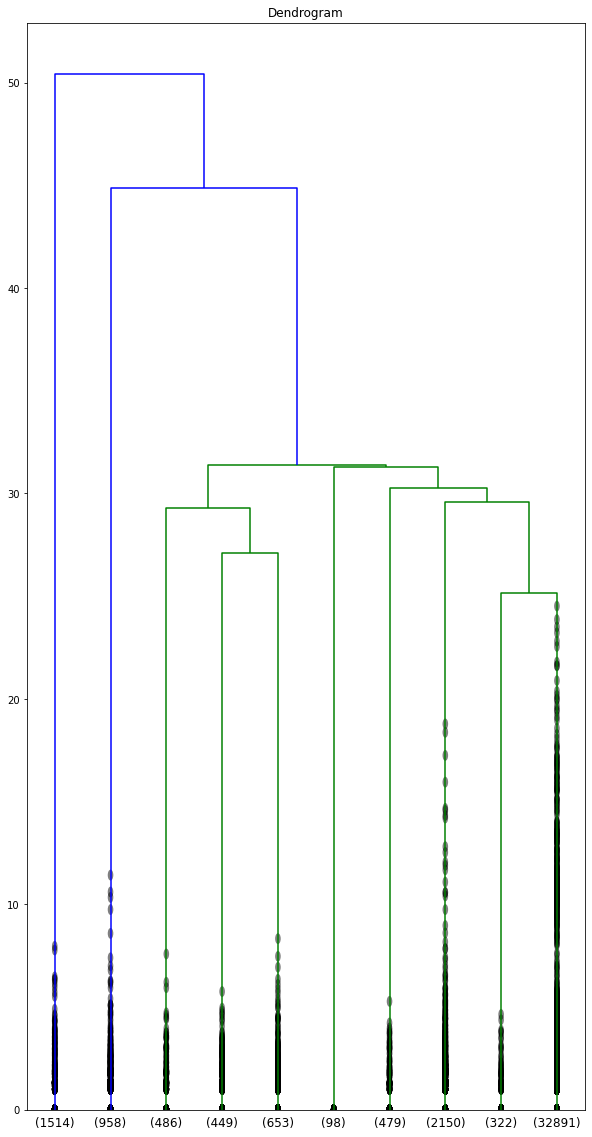

         count    ratio
cluster                
1         1514  0.03785
2          958  0.02395
3         1588  0.03970
4           98  0.00245
5        35842  0.89605
Cluster 1
                                      name  AVGCluster       AVG     Uplift
-51812607   Тинькофф Российская Премьер-Ли    0.088507  0.005825  15.194380
-101982925                         МАТЧ ТВ    0.954425  0.064175  14.872230
-45441631                 ПРИКОЛЫ | Смеяка    0.010568  0.002025   5.218781
-166302235             Литруха футбольного    0.009247  0.002375   3.893485
-33352573                      ФК «Ростов»    0.005945  0.001875   3.170410
-30738633                  ПФК ЦСКА Москва    0.009908  0.003575   2.771337
-28402905    NBA. Новости | НБА-Новости.РФ    0.005284  0.002500   2.113606
-23783750                             AUTO    0.004624  0.002200   2.101597
-79858706                  Нижний Новгород    0.003963  0.002150   1.843261
-33377621   СПОРТИВНАЯ БИБЛИОТЕКА | Fitnes    0.004624  0.0027

In [14]:
clustering(matchtv_data, 40000, 5)

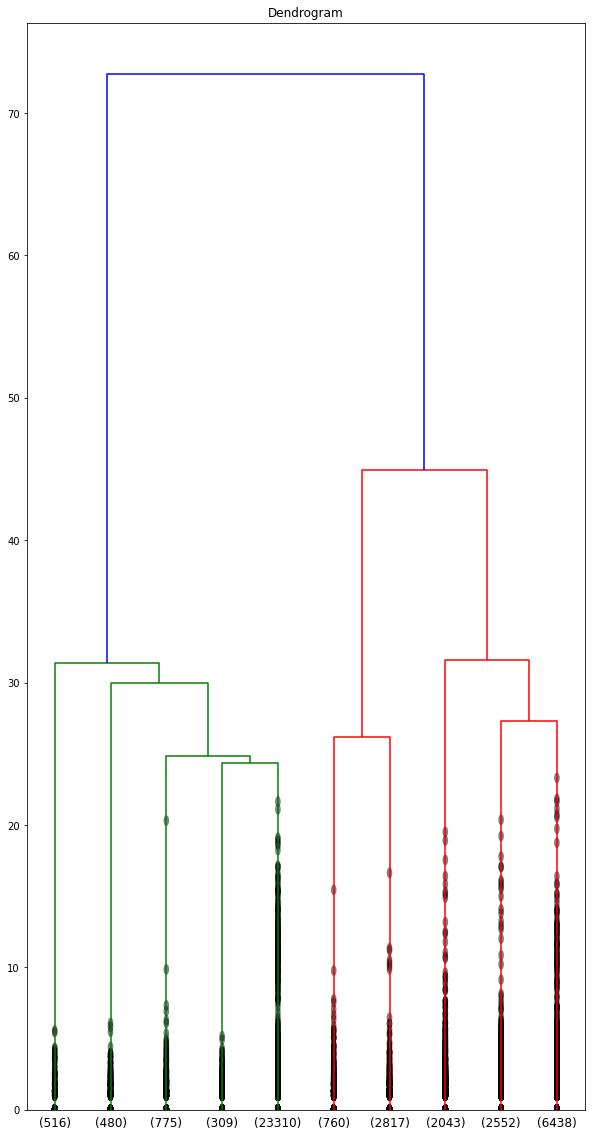

         count     ratio
cluster                 
1          516  0.012900
2        24874  0.621850
3         3577  0.089425
4         2043  0.051075
5         8990  0.224750
Cluster 1
                                name  AVGCluster       AVG     Uplift
-91050183        Леонардо Дай Винчик    0.996124  0.023950  41.591818
-78996568                 Combo Vine    0.021318  0.002325   9.168959
-45745333                   4ch inc.    0.032946  0.003650   9.026229
-138415718           Девочку затянет    0.017442  0.002575   6.773538
-67580761                         КБ    0.017442  0.003200   5.450581
-37143284                    Обо мне    0.009690  0.001825   5.309547
-123675921              MORGENSHTERN    0.017442  0.003325   5.245672
-57846937                        MDK    0.032946  0.007575   4.349272
-44901473                       ШАРЮ    0.011628  0.002675   4.346881
-145742422  Экстра Приколы ٩(͡๏̯͡๏)۶    0.011628  0.003025   3.843936



Cluster 2
                                

In [10]:
clustering(ctc_data, 40000, 5)

# Вывод

В данном эксперименте мы попытались сегментировать пользователей по их интересам. Кластеризация выполнялась с помощью иерархического алгоритма из модуля fastcluster. Сами интересы определяли исходя из того, на какие сообщества подписаны люди подписаны. Если посмотреть получившиеся кластеры, то в каждом из пабликов можно выделить основные кластеры, такие как: Музыка, Телевидение, Футбол, Юмор.

В целом, сегментация получилась не очень чёткой, это подталкивает на мысль, что идея проводить сегментацию основываясь на подписках пользователей либо требует больше данных для анализа, либо изначально не совсем верна.

